In [2]:
# %matplotlib notebook
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Input, Dense, LSTM, Reshape,Concatenate 
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.random import set_seed
# from spektral.layers import GCNConv, GlobalSumPool, DiffPool
import keras.backend as K
from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess
from graphnn.datasets import *
from extraction.extractionvalues import *


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
set_seed(0)

airports = ICAOTOP10
lookback = 8 # steps
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 2e-4  # Learning rate


In [5]:
graphData = FlightNetworkDataset(airports, timeslotLength=60, start=datetime(2019,3,1))

100%|██████████| 10/10 [00:00<00:00, 29.49it/s]


In [6]:
print("Datapoints:", len(graphData))

N = len(airports)  # Number of nodes in the graph
F = graphData.n_node_features  # Original size of node features
n_out = graphData.n_labels  # Number of classes

Datapoints: 720


In [7]:
"""Version 1"""

x_in = Input(shape=(N, F), name="Features")
a_in = Input((N, N), sparse=True, name="Adjacency")

gat = GATConv(
    channels=20,
    attn_heads=12,
    # concat_heads=False,
    # activation="relu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([x_in, a_in])

# reshaper = Concatenate()
# lstm1 = LSTM(F, return_sequences=True)(reshaper)
# lstm2 = LSTM(20)(lstm1)
dense1 = Dense(20)(gat)
drp = Dropout(0.2)
dense2 = Dense(10)(dense1)
outtput = Dense(2)(dense2)

model = Model(inputs=[x_in, a_in], outputs=outtput)



('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(None, 10, 17)]     0           []                               
                                                                                                  
 Adjacency (InputLayer)         [(None, 10, 10)]     0           []                               
                                                                                                  
 gat_conv (GATConv)             (None, 10, 240)      4800        ['Features[0][0]',               
                                                                  'Adjacency[0][0]']              
                       

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)
model.summary()

In [22]:

# Train model
# 720 points total 504 648 
loader_tr = BatchLoader(graphData[0:504], shuffle=False)
loader_val = BatchLoader(graphData[504: (504+144)], shuffle=False)
loader_test = BatchLoader(graphData[(504+144)::], shuffle=False, epochs=1)

In [9]:
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_val.load(),
    validation_steps=loader_val.steps_per_epoch,
    epochs=30,
    callbacks=[EarlyStopping(patience=30, restore_best_weights=True)],
    verbose=1,
)

Epoch 1/30
504/504 [==============================] - 6s 9ms/step - loss: 8.6719 - acc: 0.5708 - val_loss: 5.6200 - val_acc: 0.5097
Epoch 2/30
504/504 [==============================] - 5s 9ms/step - loss: 6.1363 - acc: 0.6101 - val_loss: 5.8342 - val_acc: 0.5611
Epoch 3/30
504/504 [==============================] - 5s 10ms/step - loss: 5.7171 - acc: 0.6188 - val_loss: 6.1387 - val_acc: 0.6431
Epoch 4/30
504/504 [==============================] - 5s 9ms/step - loss: 5.6435 - acc: 0.6238 - val_loss: 6.0001 - val_acc: 0.6625
Epoch 5/30
504/504 [==============================] - 5s 9ms/step - loss: 5.4496 - acc: 0.6333 - val_loss: 4.9756 - val_acc: 0.5306
Epoch 6/30
504/504 [==============================] - 5s 9ms/step - loss: 5.2863 - acc: 0.6397 - val_loss: 4.9823 - val_acc: 0.6743
Epoch 7/30
504/504 [==============================] - 5s 10ms/step - loss: 5.1899 - acc: 0.6556 - val_loss: 5.8055 - val_acc: 0.6382
Epoch 8/30
504/504 [==============================] - 5s 9ms/step - loss: 

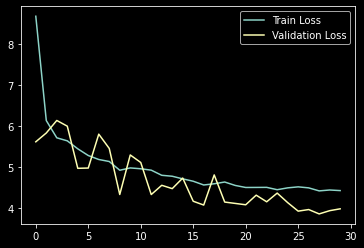

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

72/72 [==============================] - 0s 6ms/step


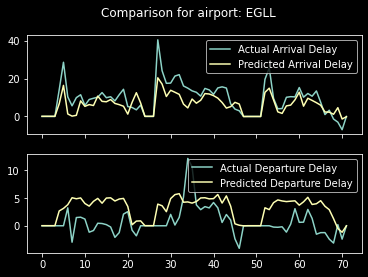

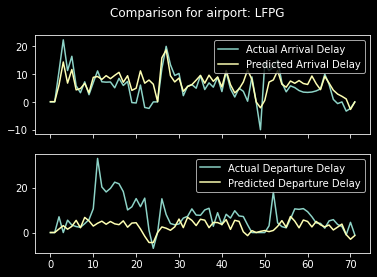

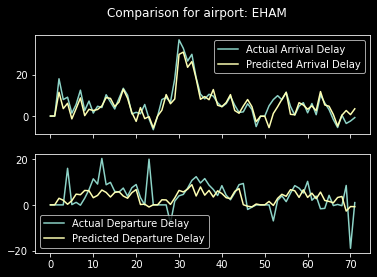

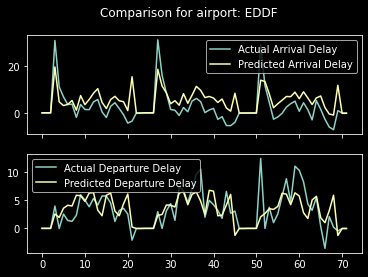

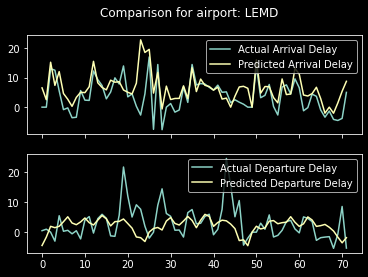

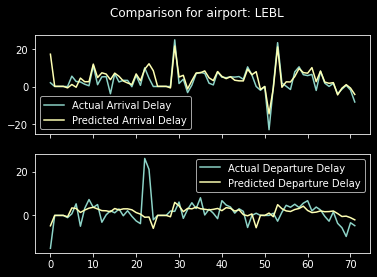

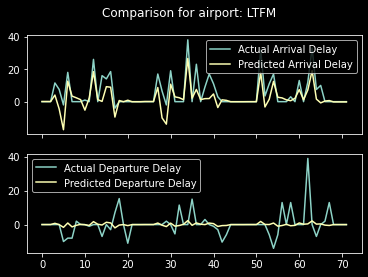

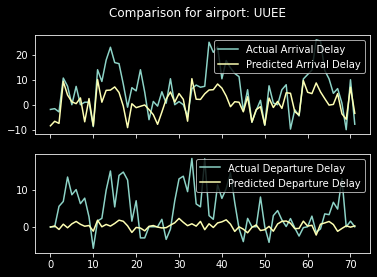

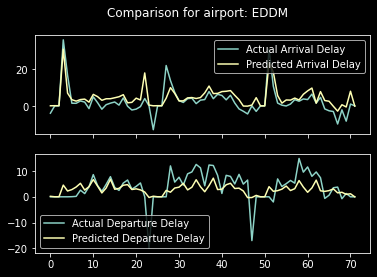

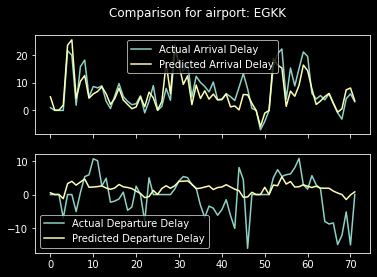

In [23]:
timeSlice = 504+144
# timeSlice = 717
# loader_test = BatchLoader(graphData[timeSlice::], shuffle=False, epochs=1)
# loader_test = BatchLoader(graphData[(504+144)::], shuffle=False, epochs=1)
# print(len(graphData[timeSlice::]))
# print(loader_test)


ypredFull = model.predict(loader_test, verbose=1)
yactualFull = np.array([g.y for g in graphData[timeSlice::]])
# airport_index = 0
def plotComparison(airport_index, ypredFull=ypredFull, yactualFull=yactualFull):
    ypred = ypredFull[:,airport_index,:]
    yactual = yactualFull[:,airport_index,:]

    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(yactual[:, 0], label="Actual Arrival Delay")
    axs[1].plot(yactual[:, 1], label="Actual Departure Delay")
    axs[0].plot(ypred[:, 0], label="Predicted Arrival Delay")
    axs[1].plot(ypred[:, 1], label="Predicted Departure Delay")
    axs[0].legend()
    axs[1].legend()
    plt.suptitle(f"Comparison for airport: {airports[airport_index]}")

for airportidx in range(0,len(airports)):
    plotComparison(airportidx)
# plotComparison(2)
# plt.show()
# graphData.visualiseGraph(timeSlice)